# Train Model

Text

## Import Packages

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## Define Functions

In [2]:
def get_arrays(df):
    """
    Extracts features, target variable, coordinates, dates, and model scenario names from a DataFrame.
    
    This function assumes a specific structure of the DataFrame where:
    - The first two columns are spatial coordinates,
    - The third column contains dates,
    - The last column is the target variable, and
    - All other columns (from the fourth to the second-last) are feature variables.
    
    Parameters:
    - df (pd.DataFrame): The input DataFrame from which to extract the data.
    
    Returns:
    - tuple: A tuple containing the following elements:
        - X (pd.DataFrame): The feature variables (all columns from the fourth to the second-last).
        - y (pd.Series): The target variable (the last column).
        - coords (pd.DataFrame): The spatial coordinates (the first two columns).
        - dates (pd.Series): The dates (the third column).
        - models_scenarios (pd.Index): The column names of the DataFrame, representing model scenarios.
    """
    X = df.iloc[:, 3:-1]
    y = df.iloc[:, -1]
    coords = df.iloc[:, :2]
    times = df.iloc[:, 2]
    models_scenarios = df.columns[3:-1]

    return X, y, coords, times, models_scenarios


In [3]:
def to_rolling(df, window=90):
    """
    Converts the data in a given dataframe to a rolling mean with a specified window size,
    grouped by time and averaged within each group. It returns a DataFrame with the 'time'
    column moved after the first two columns and with rows containing NA values dropped.

    Parameters:
    - df (pd.DataFrame): The input dataframe to be processed. 
      It must contain a 'time' column to group by and perform rolling operations.
    - window (int): The window size for the rolling mean calculation, with a default of 90.

    Returns:
    - pd.DataFrame: A DataFrame after applying a rolling mean operation on the grouped data,
      dropping rows with NA values, and reordering the columns to move 'time' to the third position.
    """
    # Group by the time column and set it as the index
    df = df.groupby('time').mean().reset_index()
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)

    # Apply a rolling mean
    df_rolling = df.rolling(window).mean().dropna().reset_index()
    col = df_rolling.pop('time')
    df_rolling.insert(2, 'time', col)

    return df_rolling


In [4]:
def train_multiple_models(df_train, df_validate, model, rolling=False, window=90, coefs=False):
    """
    Trains models on training data and evaluates on validation data for 
    each unique latitude and longitude pair, optionally using rolling windows.

    Parameters:
    - df_train (pd.DataFrame): DataFrame containing training data.
    - df_validate (pd.DataFrame): DataFrame containing validation data.
    - model (Any): The machine learning model to be trained.
    - rolling (bool): Whether to use rolling windows for training.
    - window (int): The size of the rolling window in days.

    Returns:
    A DataFrame containing the latitude and longitude of each location and the 
    corresponding training and validation RMSE and R2 metrics.
    """
    # Extract coordinates from training data
    _, _, coords, _, _ = get_arrays(df_train)

    # Remove duplicate coordinates
    coords = coords.drop_duplicates()
    lats = coords['lat'].to_list()
    lons = coords['lon'].to_list()

    results = {}

    for lat, lon in zip(lats, lons):
        metrics = {}

        # Filter the dataframes for the current coordinates
        df_train_filtered = df_train[(df_train['lat'] == lat) & (df_train['lon'] == lon)]
        df_validate_filtered = df_validate[(df_validate['lat'] == lat) & (df_validate['lon'] == lon)]

        if rolling:
            # Apply rolling window to the training data
            df_train_filtered = to_rolling(df_train_filtered, window=window)
            # Concatenate and filter training and validation data
            df_concat = pd.concat([df_train_filtered, df_validate_filtered])
            df_concat = df_concat[df_concat['time'] > pd.to_datetime(df_train_filtered['time'].max()) - pd.Timedelta(days=window)]
            df_validate_filtered = to_rolling(df_concat, window=window)

        # Extract arrays for model training and validation
        X_train, y_train, _, _, _ = get_arrays(df_train_filtered)
        X_validate, y_validate, _, _, _ = get_arrays(df_validate_filtered)
            
        # Fit the model and predict
        reg = model.fit(X_train, y_train)
        preds_train = reg.predict(X_train)
        preds_validate = reg.predict(X_validate)

        # Calculate and store metrics
        metrics['train_rmse'] = (mean_squared_error(y_train, preds_train) ** 0.5).round(3)
        metrics['train_r2'] = r2_score(y_train, preds_train).round(3)
        metrics['validate_rmse'] = (mean_squared_error(y_validate, preds_validate) ** 0.5).round(3)
        metrics['validate_r2'] = r2_score(y_validate, preds_validate).round(3)
        if coefs:
            metrics['coefs'] = reg.coef_

        results[(lat, lon)] = metrics

    # Convert results to DataFrame
    df_results = pd.DataFrame(results).transpose().reset_index()
    df_results = df_results.rename(columns={'level_0': 'lat', 'level_1': 'lon'})

    return df_results


## Define Variables

In [5]:
WINDOW = 90

In [6]:
# Load train dataframe
df_train = pd.read_parquet('../data/processed/df_easternmountain_train.parquet.gzip')
df_train['time'] = pd.to_datetime(df_train['time'])

# Define inputs, outputs, and labels
X_train, y_train, coords_train, time_train, models_train = get_arrays(df_train)

In [7]:
# Load validate dataframe
df_validate = pd.read_parquet('../data/processed/df_easternmountain_validate.parquet.gzip')
df_validate['time'] = pd.to_datetime(df_validate['time'])

# Define inputs, outputs, and labels
X_validate, y_validate, coords_validate, time_validate, models_validate = get_arrays(df_validate)

## Explore Data

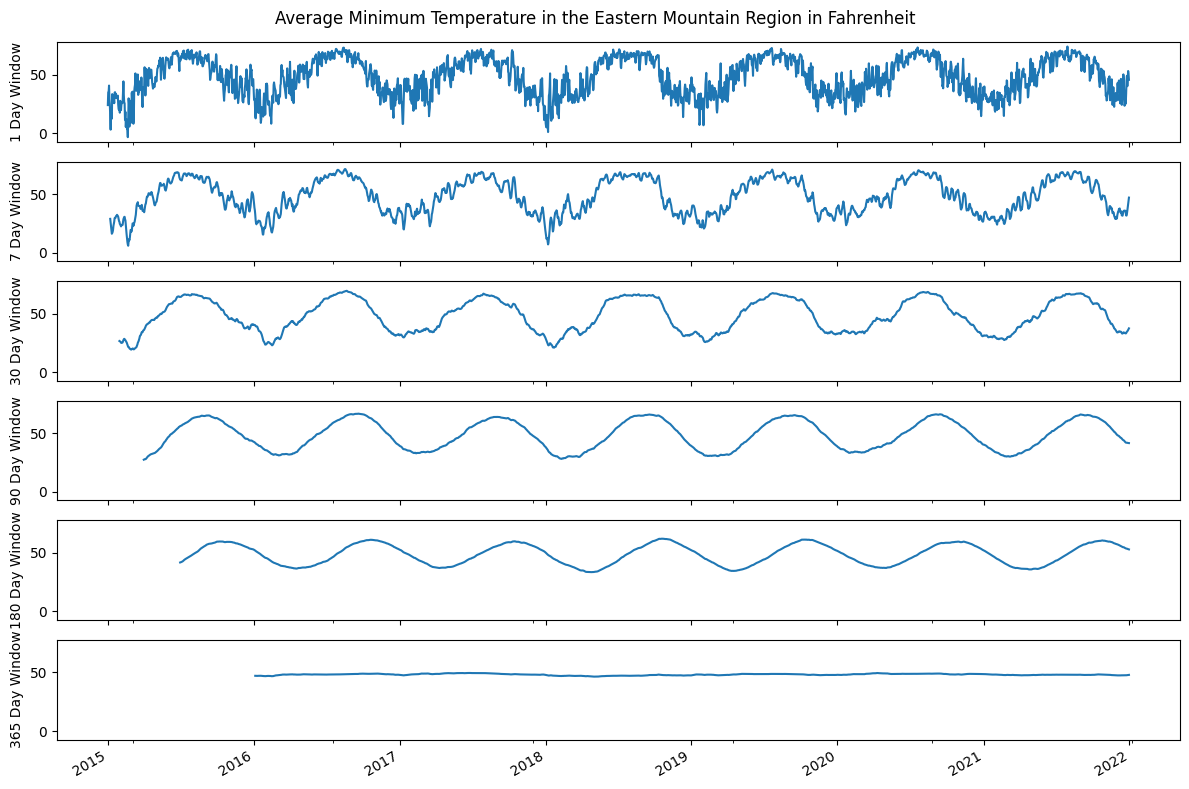

In [8]:
# Plot the average minimum temperature in the Eastern Mountain region for several rolling windows
data = df_train.groupby('time').mean().iloc[:, -1].reset_index()
data['time'] = pd.to_datetime(data['time'])

windows = [1, 7, 30, 90, 180, 365]

fig, axs = plt.subplots(
    nrows=len(windows), 
    ncols=1, 
    figsize=(12, 8), 
    sharex=True, 
    sharey=True, 
    tight_layout=True,
)

for i, window in enumerate(windows):
    data.set_index('time').rolling(window).mean().plot(ax=axs[i], legend=False, xlabel='', ylabel=f'{window} Day Window')

fig.suptitle('Average Minimum Temperature in the Eastern Mountain Region in Fahrenheit')

plt.show()

## Train Models

### Establish Baseline

In [9]:
# Average train dataframe across models and scenarios
train_mse = mean_squared_error(y_train, X_train.mean(axis=1)) ** 0.5
train_r2 = r2_score(y_train, X_train.mean(axis=1))
print('Train Baseline MSE:', f'{train_mse.round(3)}')
print('Train Baseline R2:', f'{train_r2.round(3)}')

# Average validate dataframe across models and scenarios
validate_mse = mean_squared_error(y_validate, X_validate.mean(axis=1)) ** 0.5
validate_r2 = r2_score(y_validate, X_validate.mean(axis=1))
print('Validate Baseline MSE:', f'{validate_mse.round(3)}')
print('Validate Baseline R2:', f'{validate_r2.round(3)}')

Train Baseline MSE: 8.514
Train Baseline R2: 0.715
Validate Baseline MSE: 8.554
Validate Baseline R2: 0.737


### Ordinary Least Squares Regression

In [10]:
# Instantiate a model
ols = LinearRegression()

# Train a model for each coordinate and assess performance
results = train_multiple_models(df_train, df_validate, ols, rolling=False)
results.mean().iloc[2:].round(3)

train_rmse       7.767
train_r2         0.758
validate_rmse    8.986
validate_r2      0.705
dtype: float64

In [11]:
# Instantiate a model
ols = LinearRegression()

# Train a rolling model for each coordinate and assess performance
results = train_multiple_models(df_train, df_validate, ols, rolling=True)
results.mean().iloc[2:].round(3)

train_rmse       0.490
train_r2         0.998
validate_rmse    3.360
validate_r2      0.909
dtype: float64

### Elastic-Net Regression

In [12]:
# Instantiate a model
eln = ElasticNet(alpha=1.0, max_iter=10000, random_state=42)

# Train a model for each coordinate and assess performance
results = train_multiple_models(df_train, df_validate, eln, rolling=False)
results.mean().iloc[2:].round(3)

train_rmse       7.778
train_r2         0.758
validate_rmse    8.891
validate_r2      0.711
dtype: float64

In [13]:
# Instantiate a model
eln = ElasticNet(alpha=1.0, max_iter=10000, positive=True, random_state=42)

# Train a model for each coordinate and assess performance
results = train_multiple_models(df_train, df_validate, eln, rolling=True)
results.mean().iloc[2:].round(3)

train_rmse       1.084
train_r2         0.992
validate_rmse    1.798
validate_r2      0.974
dtype: float64

In [47]:
# Augment rolling train dataframe with month and year columns
df_train_augmented = to_rolling(df_train)
df_train_augmented.insert(3, 'year', df_train_augmented['time'].dt.year)
df_train_augmented.insert(4, 'month', df_train_augmented['time'].dt.month)
df_train_augmented.drop('time', axis=1, inplace=True)

# Define features and target variable
X_train_augmented = df_train_augmented.iloc[:, :-1]
y_train_augmented = df_train_augmented.iloc[:, -1]

# Scale features
scaler = StandardScaler().fit(X_train_augmented)
X_train_scaled = scaler.transform(X_train_augmented)

# Augment rolling validate dataframe with month and year columns
df_concat = pd.concat([df_train, df_validate])
df_concat = df_concat[df_concat['time'] > pd.to_datetime(df_train['time'].max()) - pd.Timedelta(days=WINDOW)]
df_validate_augmented = to_rolling(df_concat, window=WINDOW)
df_validate_augmented.insert(3, 'year', df_validate_augmented['time'].dt.year)
df_validate_augmented.insert(4, 'month', df_validate_augmented['time'].dt.month)
df_validate_augmented.drop('time', axis=1, inplace=True)

# Define features and target variable
X_validate_augmented = df_validate_augmented.iloc[:, :-1]
y_validate_augmented = df_validate_augmented.iloc[:, -1]

# Scale features
X_validate_scaled = scaler.transform(X_validate_augmented)

# Train model
eln = ElasticNet(alpha=1.0, max_iter=10000, positive=True, random_state=42).fit(X_train_scaled, y_train_augmented)

preds_train = eln.predict(X_train_scaled)
preds_validate = eln.predict(X_validate_scaled)

rmse_train = mean_squared_error(y_train_augmented, preds_train) ** 0.5
r2_train = r2_score(y_train_augmented, preds_train)
rmse_validate = mean_squared_error(y_validate_augmented, preds_validate) ** 0.5
r2_validate = r2_score(y_validate_augmented, preds_validate)

print(rmse_train, r2_train)
print(rmse_validate, r2_validate)

1.469066039124412 0.9853885989130164
1.8662138083049902 0.9769982878406716


In [14]:
## SHAPLEY
## https://www.kaggle.com/code/prashant111/explain-your-model-predictions-with-shapley-values

In [15]:
## NEXT STEPS:
## EXPLORE WHETHER R2 IS CONSISTENT ACROSS LOCATIONS
## EXPLORE ADDING SPATIAL AND TEMPORAL FEATURES TO A SINGLE MODEL
## PLOT RESULTS
## CREATE CLASS?